In [4]:
%pip install -r requirements.txt

  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 2.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 21.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.3 MB/s eta 0:00:00:00:0100:01
Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
Using cached nvidia_cusolver_cu12-11.4.5.107-py

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from tqdm.notebook import tqdm
import os
import random
from sklearn.model_selection import train_test_split

In [18]:
def load_image_paths(root_dir):
    original_dir = os.path.join(root_dir, "original")
    degraded_dir = os.path.join(root_dir, "degraded")
    
    original_images = [os.path.join(original_dir, img) for img in os.listdir(original_dir)]
    degraded_images = [os.path.join(degraded_dir, img) for img in os.listdir(degraded_dir)]
    print(degraded_images[:5])
    # Mapping original to degraded
    mapping = {}
    for orig_path in original_images:
        base_name = os.path.basename(orig_path)
        # print(base_name)
        idx, barcode, _ = base_name.split('_')
        # print([img for img in degraded_images])
        degraded_versions = [img for img in degraded_images if img.startswith(f"../data/ean13/degraded/{idx}_{barcode}")]
        mapping[orig_path] = degraded_versions
    
    return mapping

# Assuming '/data/tmp' is your root directory
root_dir = '../data/ean13'
image_paths = load_image_paths(root_dir)

# Splitting into train and test sets
original_images = list(image_paths.keys())
train_orig, test_orig = train_test_split(original_images, test_size=0.2, random_state=42)

# Creating train and test mappings
train_mapping = {orig: image_paths[orig] for orig in train_orig}
test_mapping = {orig: image_paths[orig] for orig in test_orig}

['../data/ean13/degraded/282_9021415359676_ean13_2.png', '../data/ean13/degraded/308_7480574960796_ean13_23.png', '../data/ean13/degraded/397_1834558412119_ean13_10.png', '../data/ean13/degraded/474_6844512252717_ean13_3.png', '../data/ean13/degraded/185_1480106621887_ean13_6.png']


In [19]:
class ImageDataset(Dataset):
    def __init__(self, mapping, transform=None):
        self.mapping = mapping
        self.transform = transform
        self.original_images = list(mapping.keys())
    
    def __len__(self):
        return len(self.original_images)
    
    def __getitem__(self, idx):
        orig_path = self.original_images[idx]
        degraded_paths = self.mapping[orig_path]
        
        # Example: loading the first degraded image
        degraded_path = random.choice(degraded_paths) # Randomly select one for variability
        orig_image = Image.open(orig_path).convert('L')
        degraded_image = Image.open(degraded_path).convert('L')
        
        if self.transform:
            orig_image = self.transform(orig_image)
            degraded_image = self.transform(degraded_image)
        
        return degraded_image, orig_image

In [20]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_mapping, transform=transform)
test_dataset = ImageDataset(test_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([1, 1, 256, 512])


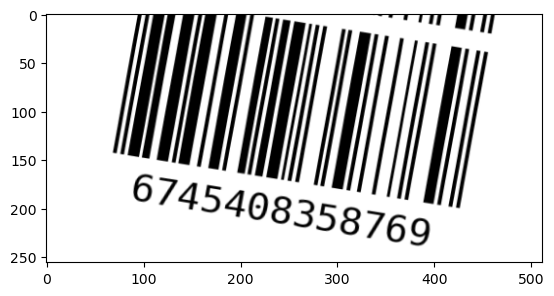

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy array
def imshow(img):
    img = img.numpy() # Convert tensor to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from CxHxW to HxWxC
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next() to get the next batch

# Show images for the first image in the batch
print(images[0].unsqueeze(0).shape)
imshow(torchvision.utils.make_grid(images[0].unsqueeze(0)))

In [22]:
from models import Discriminator, Generator

In [23]:
generator = Generator()
discriminator = Discriminator()

In [24]:
for data in train_loader:
    print(data[0].shape)
    print(data[0][0].shape)
    break

torch.Size([4, 1, 256, 512])
torch.Size([1, 256, 512])


In [25]:
# Hyperparameters
lr = 0.0002
beta1 = 0.5  # For Adam optimizer
epochs = 100
batch_size = 4

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
for epoch in range(epochs):
    num_batches = 0
    for degraded_images, original_images in train_loader: 
        # Prepare real and fake labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Train Discriminator
        discriminator.zero_grad()
        
        # Train with real images
        output = discriminator(original_images)
        lossD_real = criterion(output, real_labels)
        
        # Train with fake images
        # noise = torch.randn(batch_size, 1, 256, 512)
        fake_images = generator(degraded_images)
        output = discriminator(fake_images.detach())  # Detach to avoid training generator
        lossD_fake = criterion(output, fake_labels)
        
        # Backprop and optimize
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # Train Generator
        generator.zero_grad()
        
        output = discriminator(fake_images)
        lossG = criterion(output, real_labels)  # Trick discriminator into thinking fake is real
        
        lossG.backward()
        optimizerG.step()

        if num_batches % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Step [{num_batches}/{len(train_loader)}], LossD: {lossD.item()}, LossG: {lossG.item()}')
        num_batches += 1
    #print average loss after every epoch
    print(f'Epoch [{epoch}/{epochs}], LossD: {lossD.item()}, LossG: {lossG.item()}')

# Save the model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


ValueError: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 1, 30, 62])) is deprecated. Please ensure they have the same size.

## Need to figure out how the discriminator works
- What is the input output
- Visualize results every 10 epochs?